In [464]:
# Imports 

%matplotlib inline
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mplsoccer.pitch import VerticalPitch, Pitch
from formation_codes_np import get_team_np

# Variables and class used to plot the results

COLORS = ["blue","orange","grey","purple","red", "white"]
COLORMAP = mcolors.ListedColormap(COLORS)

FIELD_LENGTH_M = 105
FIELD_WIDTH_M = 68

FIELD_LENGTH_CM = FIELD_LENGTH_M*100
FIELD_WIDTH_CM = FIELD_WIDTH_M*100



class PitchPlot:
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(FIELD_LENGTH_M//8,FIELD_LENGTH_M//8))
        self.pitch = Pitch(pitch_type='tracab', pitch_length=FIELD_LENGTH_M, pitch_width=FIELD_WIDTH_M, )
        self.pitch.draw(ax=self.ax)



    def plot_points(self, pts, color="black"):
        self.pitch.plot(*np.array(pts).T, ax=self.ax, linewidth=0, marker="o", markersize=10, color=color)
        return self
    
    def plot_points_with_role(self, pts, roles):
        unique_roles = np.unique(roles)
        for r in unique_roles:
            self.plot_points(pts[:len(roles)][roles==r], color=COLORS[r])



    def triplot(self, pts, triangles, color="grey"):
        self.ax.triplot(*pts.T, triangles, color=color)
        return self
    
    def tripcolor(self, pts, triangles, facecolors, cmap = COLORMAP, alpha=.3, edgecolors="none", linewidth=0, antialiased=True, *args, **kwargs):
        self.ax.tripcolor(*pts.T, triangles, facecolors=facecolors, cmap=cmap, alpha=alpha, edgecolors=edgecolors, linewidth=linewidth, antialiased=antialiased, *args, **kwargs)
        return self
    
    def plot_edge(self, pts, color, stability, perc_stability, unstable):
        style = "dotted" if unstable else None
        width = 1 if perc_stability == np.inf else .5 if unstable else perc_stability
        self.pitch.plot(*pts.T,color=color, linestyle=style, ax=self.ax, linewidth=5*width)
        midpoint = np.mean(pts, axis=0)
        if stability < np.inf:
            angle = np.arctan2(*np.diff(pts.T[::-1]))[0]
            if angle < -np.pi/2:
                angle+=np.pi
            elif angle > np.pi/2:
                angle-=np.pi
            angle = np.rad2deg(angle)
            self.ax.text(*midpoint.T, s=f"{np.rad2deg(stability):.01f}", fontsize=9, horizontalalignment="center", verticalalignment="bottom", rotation = angle, rotation_mode="anchor")



        return self


    def plot_edges(self, pts, edges, stability, unstable, fl, fr, ml, mr, bl, br):
        max_stability = np.unique(stability)[-2]

        perc_stability = stability/max_stability
        for f, t in zip(*np.nonzero(np.triu(edges))):
            vertices = {f,t}

            if fl in vertices or fr in vertices:
                if ml in vertices:
                    color = COLORS[1]
                elif mr in vertices:
                    color = COLORS[3]
                else:
                    color = COLORS[4]
            elif br in vertices or bl in vertices:
                if ml in vertices:
                    color = COLORS[1]
                elif mr in vertices:
                    color = COLORS[3]
                else:
                    color = COLORS[0]
            elif ml in vertices:
                color = COLORS[1]
            elif mr in vertices:
                color = COLORS[3]
            else:
                color = COLORS[2]
            self.plot_edge(
                pts[[f,t]],
                color=color,
                stability=stability[f,t],
                perc_stability=perc_stability[f,t],
                unstable=unstable[f,t]
            )
        
        return self


# Generate the 10 points (players)

We use a history of tested points to retest previous player positions.

**Please note**: the plotted team has its own goal on the left, so it attacks from left to right.

In [466]:
players_history = []

## Random

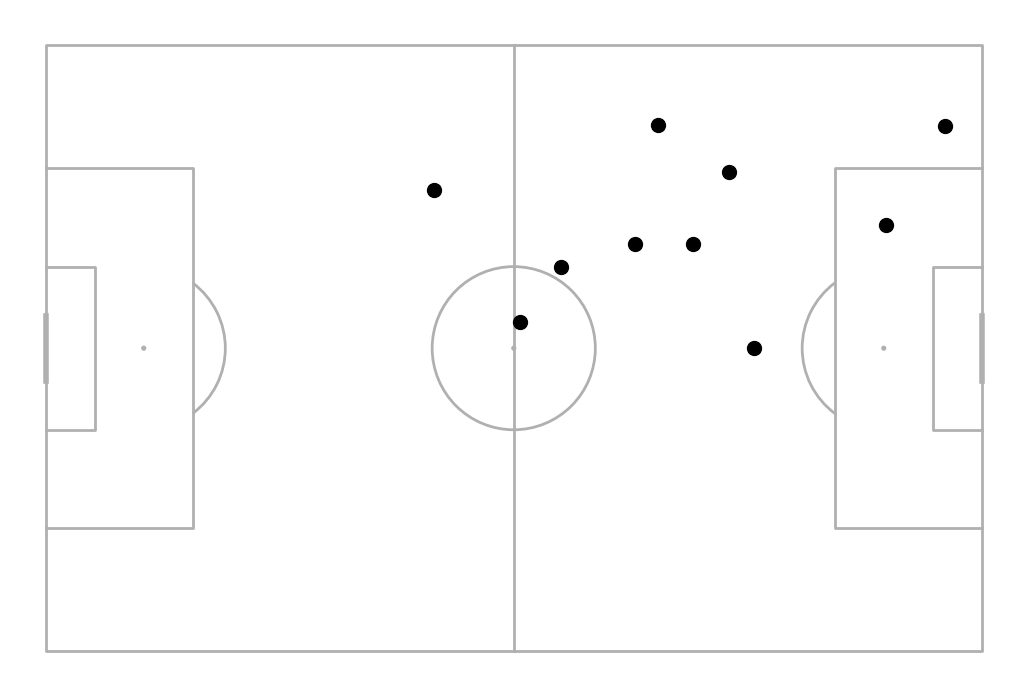

In [506]:
n_players = 10


centroid = np.array([FIELD_LENGTH_CM, FIELD_WIDTH_CM])

f = FIELD_LENGTH_CM/2
l = FIELD_WIDTH_CM/2
b, r = -f, -l

while centroid[0] <= b or centroid[0] >= f or centroid[1] <= r or centroid[1] >= l:
    centroid = np.array([
        np.random.normal(0,FIELD_LENGTH_CM/6),
        np.random.normal(0,FIELD_WIDTH_CM/6),
    ])

sigma_x = min(abs(centroid[0] - FIELD_LENGTH_CM), abs(centroid[0] + FIELD_LENGTH_CM))/6
sigma_y = min(abs(centroid[1] - FIELD_WIDTH_CM), abs(centroid[1] + FIELD_WIDTH_CM))/6

pts = np.array([
    np.random.normal(centroid[0],sigma_x, n_players),
    np.random.normal(centroid[1],sigma_y, n_players),
])
pts = pts.T


while np.any((pts >= np.array([f, l])).flatten()) or np.any((pts <= np.array([b, r])).flatten()):
    pts = np.array([
        np.random.normal(centroid[0],sigma_x, n_players),
        np.random.normal(centroid[1],sigma_y, n_players),
    ])

    pts = pts.T

players_history.append(pts)

PitchPlot().plot_points(pts)
plt.show()

## By hand

In [485]:
%matplotlib qt

n_players = 10

pitch = PitchPlot()

pts = []
def onclick(event):
    pitch.plot_points([event.xdata, event.ydata])
    pitch.fig.canvas.draw()
    pts.append([event.xdata, event.ydata])
    if len(pts)==n_players:
        plt.close()

cid = pitch.fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()



Plot the chosen points:

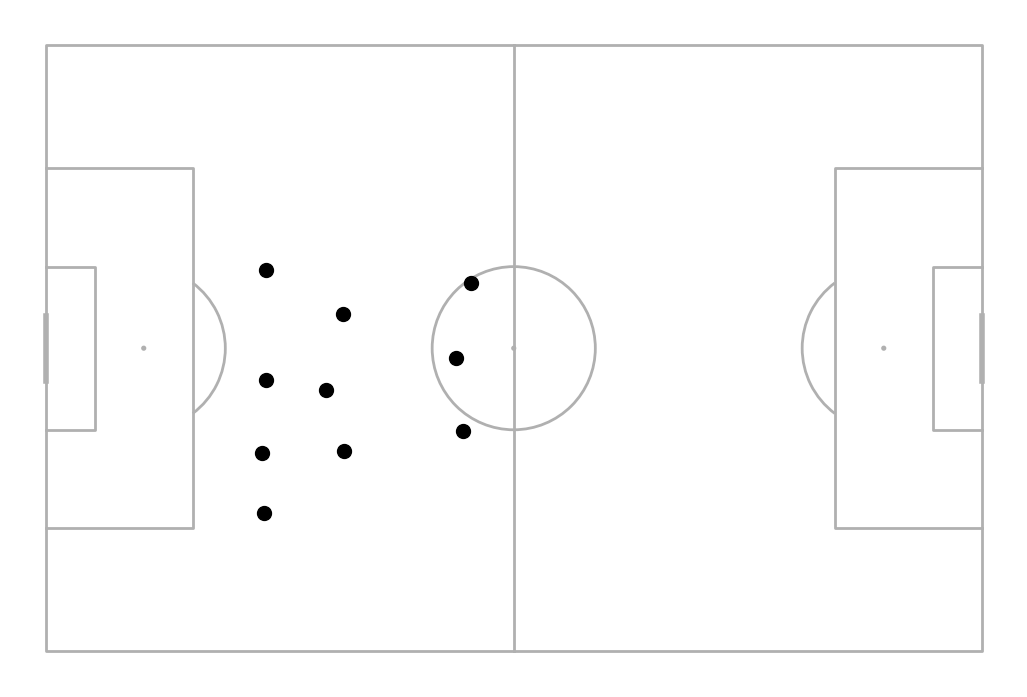

In [486]:
%matplotlib inline

pts = np.array(pts)
players_history.append(pts)

PitchPlot().plot_points(pts)
plt.show()

## From position data

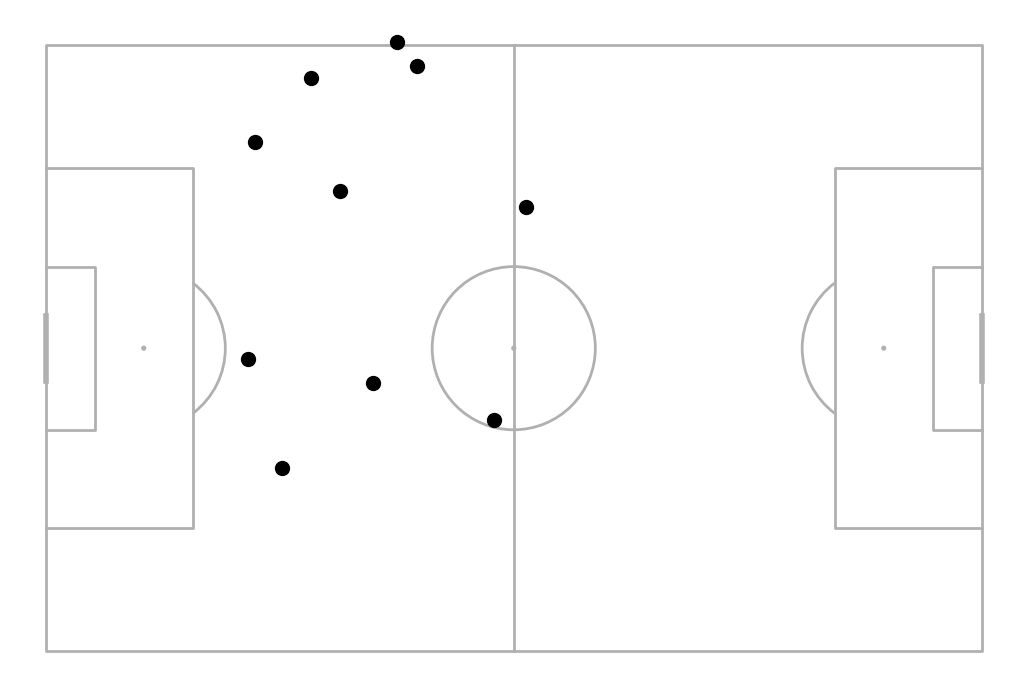

In [554]:
data = get_team_np(None, None, None, 1)
alive = data["alive"]
coords = data["coords_team_pov"][alive]
on_field = data["on_field"][alive]

frame = 800


pts = coords[frame, on_field[frame]]
n_players = np.sum(on_field[frame])
players_history.append(pts)

PitchPlot().plot_points(pts)
plt.show()

# Step one: add dummy players and compute the Delauney triangulation

For each of the four corners of the field we add a *dummy player* two meters beyond the goal line and touch line.
We then run the triangulation on all points.

In [555]:

players = np.array(players_history[-1])[:n_players]

delta = 200

# f, l = np.max(players, axis=0) + delta
# b, r = np.min(players, axis=0) - delta

f = FIELD_LENGTH_CM/2 + delta
l = FIELD_WIDTH_CM/2 + delta
b, r = -f, -l

pts = np.append(
    players,
    [
        [f,l],
        [f,r],
        [b,l],
        [b,r],
    ], axis=0
)

n_pts = len(pts)


# Indices for each of the dummy players in the pts array
fl = 10
fr = 11
bl = 12
br = 13

tri = Delaunay(pts)
simp = tri.simplices

Plot the result:

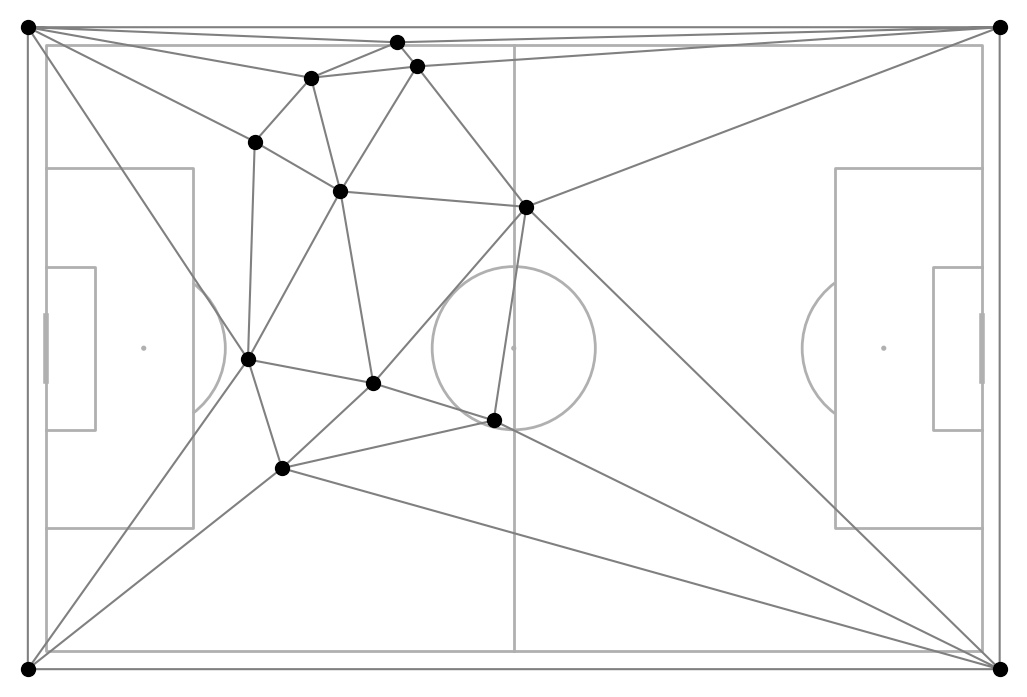

In [556]:
PitchPlot().triplot(pts,simp).plot_points(pts)
plt.show()


# Step two: find the two midplayers and add midpoints

We find the two midplayers (one for each point) as the two players that are both adjacent to top and bottom corner.

In [557]:


edges = np.zeros((n_pts, n_pts), np.bool_)
edges[simp, np.roll(simp,-1, axis=1)] = True # Adjacency matrix containing all the edges from the triangulation
edges = edges | edges.T # Make it simmetric

ml_player, mr_player = np.nonzero(edges[[fl, fr]] & edges[[bl,br]])[1]


 From this, we add the two dummy midpoints two meters beyond the side lines and in correspondance to the same position as the two midplayers.

In [558]:

mids = pts[[ml_player,mr_player]]
mids[0, 1] = l
mids[1, 1] = r


ml = 14
mr = 15

pts = np.append(pts, mids, axis=0)

And we run compute the Delaunay triangulation again.

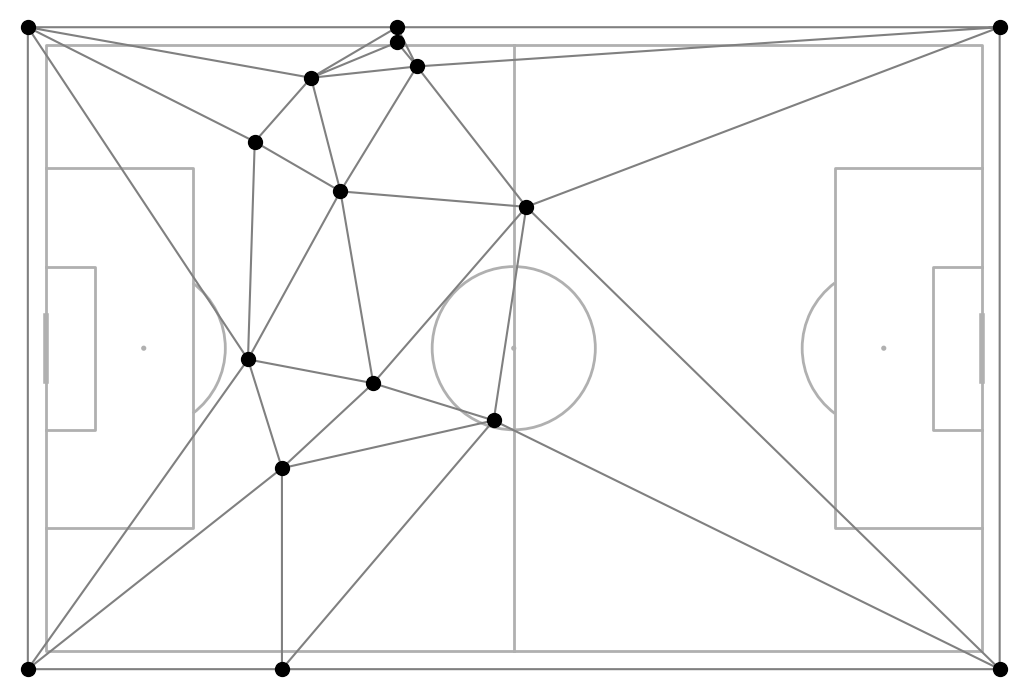

In [559]:


tri = Delaunay(pts)
simp = tri.simplices



PitchPlot().triplot(pts,simp).plot_points(pts)
plt.show()


# Step three: *color* the triangles

We now assign a *color* for each of the triangle. The color is used to represent which role the players on the perimeter of the polygon have. We use the following colors:
 - blue for back players (code `0`);
 - yellow for left player (code `1`);
 - grey for midfielders (code `2`);
 - purple for right player (code `3`);
 - red for front players (code `4`);
 - white for *neutral* area (codde `5`).
 
In this first step we assign the color using these simple rules:
 - If the perimeter of the polygon contains a front (back) dummy player, and not any side dummy player it is a front (back) polygon.
 - If the perimeter of the polygon contains both side and front (back) dummy players, it is a neutral polygon.
 - If the perimeter of the polygon contains a left (right) dummy player and no other dummy player, it is a left (right) polygon.
 - Otherwise, the polygon is a midfilder polygon

In [569]:
polygon_colors = np.zeros(len(simp), np.int16)
contains_fl = np.any(simp == fl,axis=1)
contains_fr = np.any(simp == fr,axis=1)
contains_br = np.any(simp == br,axis=1)
contains_bl = np.any(simp == bl,axis=1)
contains_ml = np.any(simp == ml,axis=1)
contains_mr = np.any(simp == mr,axis=1)

contains_f = contains_fl | contains_fr
contains_m = contains_ml | contains_mr
contains_b = contains_bl | contains_br


polygon_colors[contains_ml & ~(contains_bl | contains_fl)] = 1 # = left (yellow)
polygon_colors[~(contains_f | contains_m | contains_b)] = 2 # =  mid (grey)
polygon_colors[contains_mr & ~(contains_br | contains_fr)] = 3 # = right (purple)
polygon_colors[~contains_m & contains_f] = 4 # = front (red)
polygon_colors[(contains_m) & (contains_f | contains_b)] = 5 # = neutral (white)
# The rest is automatically 0, since we initialized the array with zeros (=  back = blue)

Plot the result:

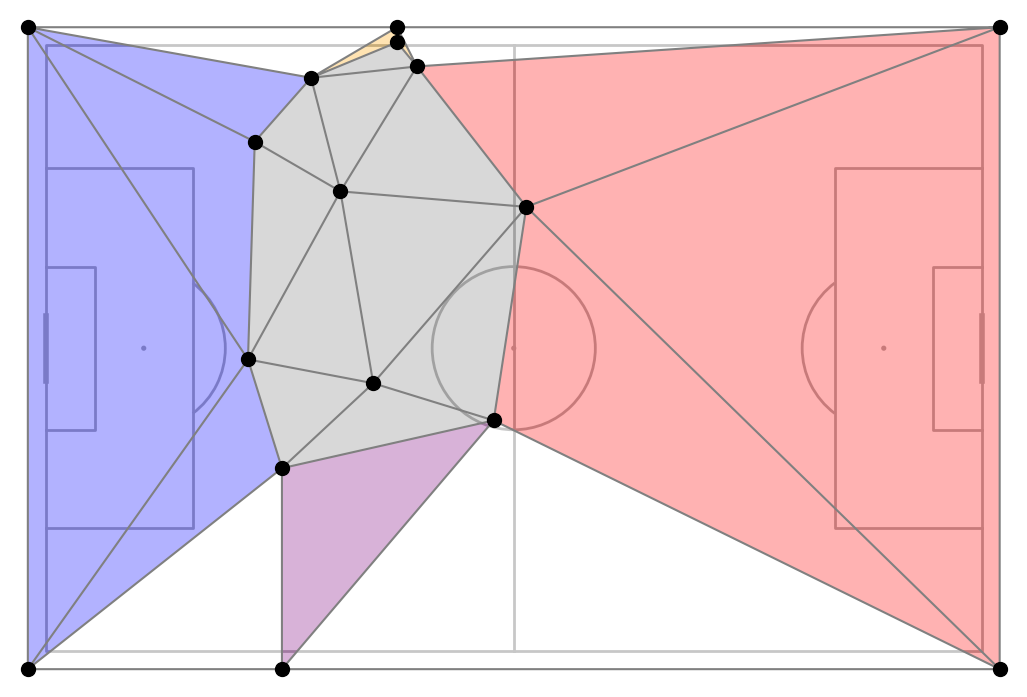

In [570]:
PitchPlot().plot_points(pts).tripcolor(pts, simp, polygon_colors).triplot(pts, simp)
plt.show()

# Step four: compute the (angular) stability

For each of the edge, except the ones between dummy players, which have infinite stability (`np.inf`), we compute its (angular) stability as follows: considering the two adjacent triangles, we sum the angles of the two opposing corners which aren't on the edge, and then we subtract the result from $\pi$ ($180\degree$).

**Please note**: since `scipy.spatial.Delaunay` guarantees us to give vertices inside triangles listed in counterclockwise order (points are in 2-D), each of the opposing corner can be represented by swapping the order of the two vertices on the edge, since this uniquely correspond to one of the two adjacent triangles. E. g. the angles' matrix at location $(A,B)$ will contain value of the angle on the corner on the left of the edge $AB$, while $(B,A)$ will contain the one on the right of the edge.

In [562]:
n_pts = len(pts)
n_tri = len(simp)
angles = np.zeros((n_pts,n_pts))
opposite = np.zeros_like(angles, dtype=np.int16) - 1
adj_tri = np.copy(opposite)
edges = np.zeros_like(opposite, np.bool_)



cycle = np.append(simp, simp[:,0].reshape(simp.shape[0],1), axis=1) # Turn triangles into cycles, by putting the first vertex at the end
segments = np.linalg.norm(np.diff(pts[cycle],axis=1),axis=2) # Compute the length of each edge of the triangle
segments_squared = segments ** 2 # Lengths squared
simp_angles = np.arccos((np.roll(segments_squared,1, axis=1) + np.roll(segments_squared,2, axis=1) - segments_squared) / (2 * np.roll(segments,1, axis=1)*np.roll(segments,2, axis=1))) # Compute the angle of the opposite corner
next_simp =  np.roll(simp,-1, axis=1)
angles[simp, next_simp] = simp_angles # Assign vertex tuple to angle (see note above)
opposite[simp, next_simp] = np.roll(simp,-2, axis=1) # Store the opposite vertex of each edge
adj_tri[simp, next_simp] = np.mgrid[0:n_tri,0:3][0] # Store to which triangle(s) is the edge adjacent to
edges[simp, np.roll(simp,-1, axis=1)] = True # Adjacency matrix containing all the edges from the triangulation
edges = edges | edges.T # Make it simmetric



stability = np.pi - (angles + angles.T)
stability[(opposite.T == -1) ^ (opposite == -1)] = np.inf # Edges that only have one oppsite corner are the ones on the convex hull, which have infinite stability


# Step five: find unstable edges

We define an edge unstable if its stability is smaller than all of the edges on the two adjacent triangles. This guarantees us that there are no larger polygons as quadrangle.

In [563]:
unstable = np.zeros_like(edges)

a,b = np.nonzero(np.triu(edges)) # only consider edges "on one direction"
c = opposite[a,b]
d = opposite[b,a]

unstable[a,b] = stability[a,b] < np.min(stability[[a,b,a,b],[c,c,d,d]], axis = 0)

unstable = unstable.T | unstable # Make it simmetric

# Step six: update colors

For unstable edges that lie between a midfield polygon and any other polygon with role $R$, we update the midfield polygon by coloring it with the role $R$.

In [564]:
unst_a, unst_b = np.nonzero(unstable)
poly_ab = polygon_colors[adj_tri[unst_a,unst_b]]
poly_ba = polygon_colors[adj_tri[unst_b,unst_a]]

polygon_colors[adj_tri[unst_a,unst_b]] = np.where((poly_ab == 2), poly_ba, poly_ab)

Plot the result (dashed are unstable edges)

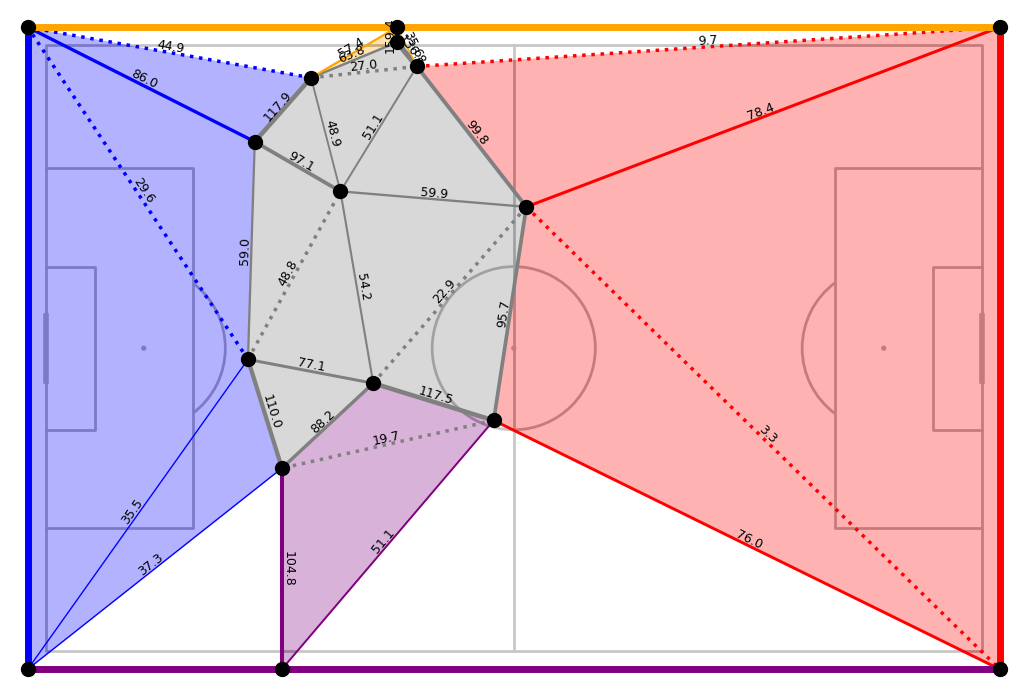

In [565]:

PitchPlot()\
    .tripcolor(pts, simp,polygon_colors)\
    .plot_edges(pts,edges, stability, unstable, fl, fr, ml, mr, bl, br)\
    .plot_points(pts)
plt.show()

# Step seven: assign roles to players

We use the following rules to assign roles to players:
 - If a player it is adjacent to a front (back) polygon, then it is a front (back) player $\rightarrow$ code `4` (`0`).
 - If the left (right) midfielder found in step two lies between two polygons of the same color, either left-left (right-right) or neutral-neutral, then it is a left (right) player $\rightarrow$ code `1` (`3`).
 - Otherwise, it is a midfielder  $\rightarrow$ code `2`.

In [566]:
roles = np.zeros(n_players, np.int16) + 2 # Default is code 2





front_players = np.unique(simp[polygon_colors == 4])
front_players = np.delete(front_players, ((front_players == fl) | (front_players == fr)))
roles[front_players] = 4

back_players = np.unique(simp[polygon_colors == 0])
back_players = np.delete(back_players, ((back_players == bl) | (back_players == br)))

roles[back_players] = 0

if polygon_colors[adj_tri[ml_player, ml]] == polygon_colors[adj_tri[ml, ml_player]]: # The color of the polygons adjacent to the edge connecting the dummy left player to the left player found initially is the same
    roles[ml_player] = 1

if polygon_colors[adj_tri[mr_player, mr]] == polygon_colors[adj_tri[mr, mr_player]]: # Same with right side
    roles[mr_player] = 3


Plot the result:

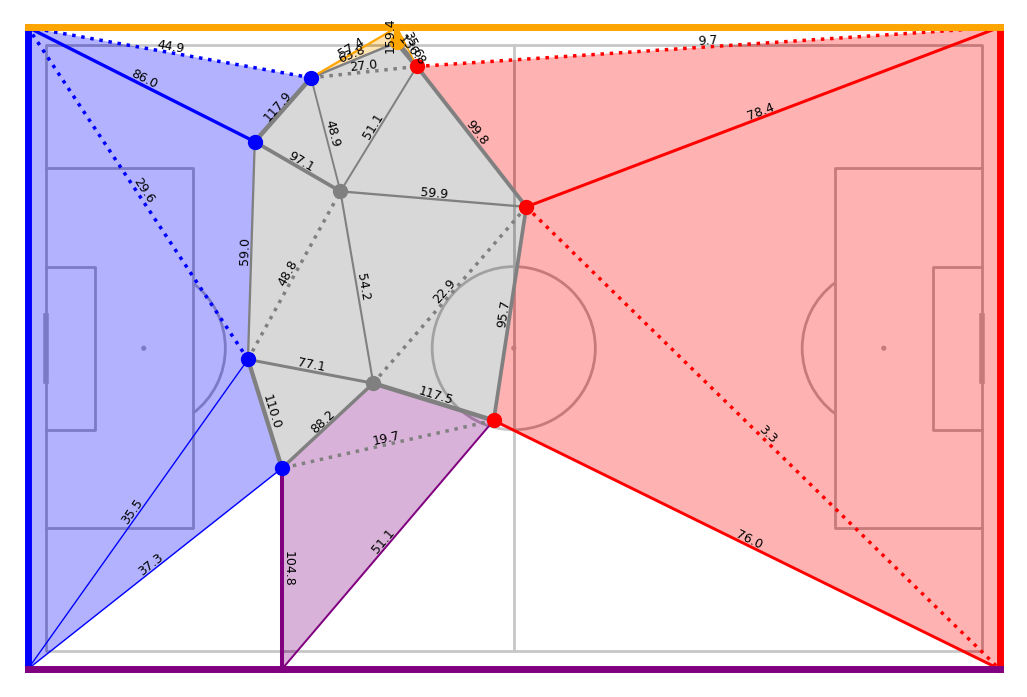

In [567]:
PitchPlot()\
    .tripcolor(pts, simp,polygon_colors)\
    .plot_edges(pts,edges, stability, unstable, fl, fr, ml, mr, bl, br)\
    .plot_points_with_role(pts,roles)
plt.show()

# Step eight: assign the code

Simply count the number of players on each role. The way we defined left and right player ensures us that there can be at most one of each in every formation.

In [568]:
n_of_codes = 5
code = np.zeros(n_of_codes, np.int16)

for c in range(n_of_codes):
    code[c] = np.sum(roles==c)

print("The code is:", "-".join([str(c) for c in code]))

The code is: 4-1-2-0-3
